# DreamBooth-LoRA

This model mixes the two learning techniques of DreamBooth and LoRA for the training of a new concept on a pre-trained diffusion model:

- MadeByOllin. (2023). madebyollin/sdxl-vae-fp16-fix [Computer software]. Hugging Face. https://huggingface.co/madebyollin/sdxl-vae-fp16-fix

## Set-Up: Check GPU and Load Packages

In [1]:
!nvidia-smi

Sat May 18 19:20:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install torch torchvision torchdata torchtext torchaudio -U -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.14 requires torch<2.3,>=1.10, but you have torch 2.3.0 which is incompatible.


In [17]:
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 1.9 MB/s eta 0:00:00a 0:00:01


In [3]:
!pip install xformers bitsandbytes transformers accelerate -q

In [4]:
!pip install git+https://github.com/huggingface/diffusers.git -q

In [5]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

--2024-05-18 19:24:31--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84307 (82K) [text/plain]
Saving to: 'train_dreambooth_lora_sdxl.py'

train_dreambooth_lo 100%[===================>]  82.33K  --.-KB/s    in 0.02s   

2024-05-18 19:24:31 (3.56 MB/s) - 'train_dreambooth_lora_sdxl.py' saved [84307/84307]



In [6]:
import torch, diffusers, transformers, accelerate, bitsandbytes

(
    torch.__version__, diffusers.__version__, 
    transformers.__version__ #, accelerate.__version__x
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

('2.3.0+cu121', '0.28.0.dev0', '4.39.3')

## Connection with Hugging Face

Follow the instructions on how to set up the HF_TOKEN for kaggle in: https://github.com/maelysjb/Comics-GenAI/blob/main/README.md#:~:text=.gitignore-,README,-.md

In [10]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HF_TOKEN")

In [11]:
from huggingface_hub import snapshot_download

local_dir = "./unicorn"
snapshot_download(
    "HF_path_to_images", # change path to image dataset
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
    token = secret_value_0
)

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

illu6.jpg:   0%|          | 0.00/469k [00:00<?, ?B/s]

illu5.jpg:   0%|          | 0.00/587k [00:00<?, ?B/s]

illu2.jpg:   0%|          | 0.00/408k [00:00<?, ?B/s]

illu3.jpg:   0%|          | 0.00/466k [00:00<?, ?B/s]

illu1.jpg:   0%|          | 0.00/428k [00:00<?, ?B/s]

illu4.jpg:   0%|          | 0.00/549k [00:00<?, ?B/s]

'/kaggle/working/unicorn'

## Uploading of the data

Change the file path below where it states: "/data/". If the images are of a different type change "jpg" to "png" or other as needed.

In [12]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

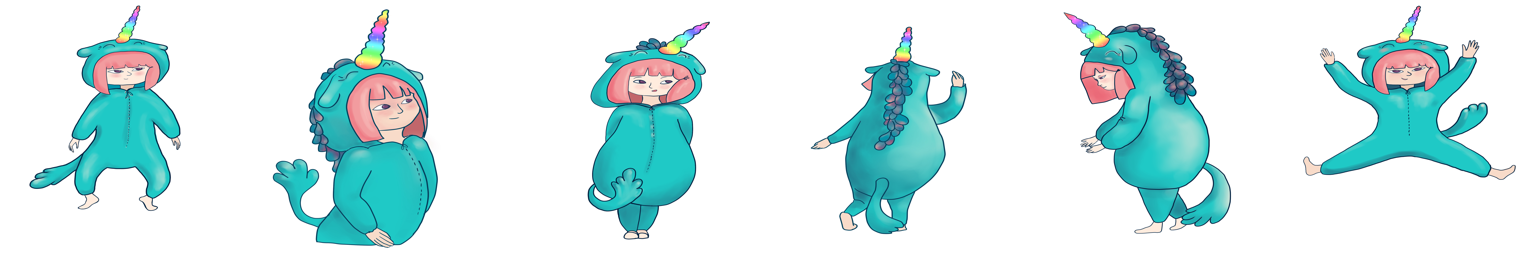

In [13]:
import glob

imgs = [Image.open(path) for path in glob.glob("./Data/*.jpg")] #change the path to the folder where the images are stored
image_grid(imgs, 1, 6)

In [14]:
!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


## Specifications and Run of the model

In [21]:
#!/usr/bin/env bash
command = (
    f'accelerate launch train_dreambooth_lora_sdxl.py '
    f'--pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" '  # pretrained diffusion model
    f'--pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" '
    f'--instance_data_dir="unicorn" '
    f'--output_dir="lora-trained-xl-colab" '
    f'--mixed_precision="fp16" '
    f'--instance_prompt="a picture of UnicornGirl" ' # prompt for the model
    f'--resolution=512 '
    f'--train_batch_size=1 '
    f'--gradient_accumulation_steps=2 '
    f'--gradient_checkpointing '
    f'--learning_rate=1e-4 ' # learning rate
    f'--lr_scheduler="constant" '
    f'--lr_warmup_steps=0 '
    f'--enable_xformers_memory_efficient_attention '
    f'--use_8bit_adam ' 
    f'--max_train_steps=2000 ' # number of training steps
    f'--checkpointing_steps=100 ' # save model every 100 steps (Adjust as desired)
    f'--seed="0" '
)

In [22]:
!{command}

2024-05-18 19:29:33.100729: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 19:29:33.100785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 19:29:33.102348: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-18 19:29:33.110730: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 19:29:33.110790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factor